## Lab 9: 3D Genome

In [1]:
import hifive
hic = hifive.HiC('project_file.txt','r')

In [2]:
# Load data in form of numpy matrix
data = hic.cis_heatmap('chr13', 1000000, datatype='fend', arraytype='full', diagonalincluded=True)

Finding fend full array for chr13:1000000-120250001... Done


In [3]:
# Get corrected values
enrichment = data[:, :, 0] / data[:, :, 1]

invalid value encountered in divide


In [4]:
import numpy as np
# Get corrected values and ignore div errors, replaces erros with nan
with np.errstate(divide='ignore', invalid='ignore'):
    enrichment = data[:, :, 0] / data[:, :, 1]

In [5]:
# Take log of enrichment values and ignore errors
with np.errstate(divide='ignore', invalid='ignore'):
    log_vals = np.log(enrichment)

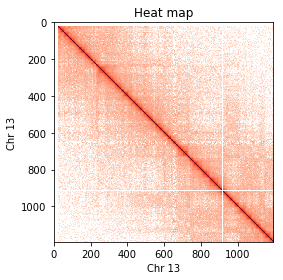

In [25]:
# Plot heat map
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(log_vals, cmap='Reds')

ax.set_xlabel("Chr 13")
ax.set_ylabel("Chr 13")

ax.set_title("Heat map")

plt.tight_layout()
plt.show()

## Compartment analysis

In [7]:
Comp = hifive.hic_domains.Compartment(hic, 100000, chroms=['chr13'], out_fname='tmp.hdf5')
Comp.write_eigen_scores('hic_comp.bed')

Casting complex values to real discards the imaginary part


In [8]:
X = Comp.positions['chr13']
Y = Comp.eigenv['chr13']

Casting complex values to real discards the imaginary part


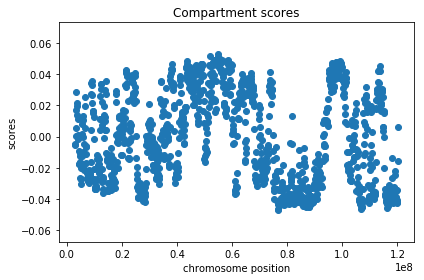

In [9]:
# Plot compartment scores
fig, ax = plt.subplots()
ax.scatter(X[:,0], Y)

ax.set_title("Compartment scores")
ax.set_xlabel("chromosome position")
ax.set_ylabel("scores")

plt.tight_layout()
plt.show()

Split genes into two groups determined by which compartment they fall at least 50% into (positive vs. negative scores) and plot each group of gene expressions separately in a violin plot in matplotlib.

In [10]:
# Import positive compartment score data as dataframe
import pandas as pd 

pos_score_df = pd.read_csv('pos_overlap', sep='\t', header=None)
header = ['chrom', 'chromStart','chromEnd','gene','fpkm']
pos_score_df.columns = header[:len(pos_score_df.columns)]

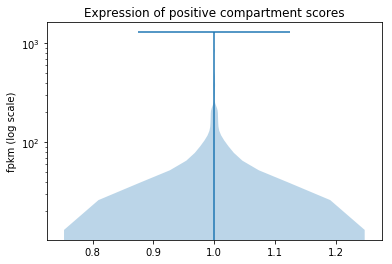

In [11]:
# Plot expression of positive compartment scores
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax.violinplot(pos_score_df['fpkm'])
ax.set_yscale('log')
ax.set_title('Expression of positive compartment scores')
ax.set_ylabel('fpkm (log scale)')

plt.show()

Positive compartment score = decreased expression?
- B-compartment

In [12]:
# Import negative compartment score data as dataframe
neg_score_df = pd.read_csv('neg_overlap', sep='\t', header=None)
header = ['chrom', 'chromStart','chromEnd','gene','fpkm']
neg_score_df.columns = header[:len(neg_score_df.columns)]

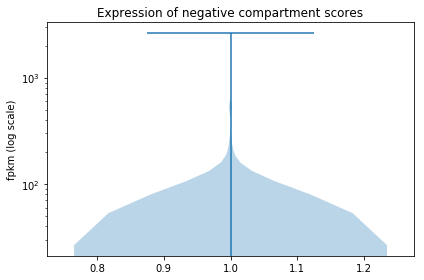

In [13]:
# Plot expression of negative compartment scores
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax.violinplot(neg_score_df['fpkm'])
ax.set_yscale('log')
ax.set_title('Expression of negative compartment scores')
ax.set_ylabel('fpkm (log scale)')

plt.tight_layout()
plt.show()

Negative compartment scores = increased expression?
- A compartment

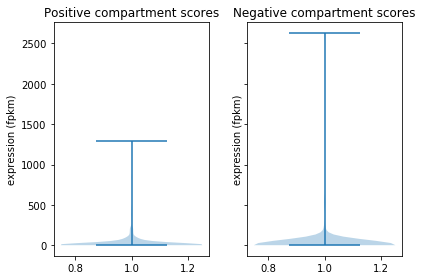

In [14]:
# Combine plots
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(ncols=2, sharey=True)

ax[0].violinplot(pos_score_df['fpkm'])
ax[0].set_title('Positive compartment scores')
ax[0].set_ylabel('expression (fpkm)')

ax[1].violinplot(neg_score_df['fpkm'])
ax[1].set_title('Negative compartment scores')
ax[1].set_ylabel('expression (fpkm)')

plt.tight_layout()
plt.show()

Based on this, the negative compartment score genes have higher expression and correspond to A-compartment. The positive compartment score genes correspond to B-compartment.

## Expression vs. Repression

Using the plot you just made, you should be able to tell which gene set corresponds to A-compartment (higher expression) and which to the B-compartment. Use this to properly label your violin plot. 

The last step is to extract H3K27me3 data for each gene body from chromosome 13 and plot versus expression in two plots, one for A-compartment gene set and one for B-compartment gene set.

In [15]:
import pyBigWig
bw = pyBigWig.open('data/WT_H3K27me3.bw')

In [16]:
# Get H3k27me3 signal for each gene body and store in list with gene name
pos_signal_list = []
for line in open('pos_overlap'):
    cols = line.strip().split()
    vals = bw.stats('chr13', int(cols[1]), int(cols[2]), type='sum')
    pos_signal_list.append([cols[3]]+vals)
bw.close()

In [17]:
len(pos_signal_list)

593

In [18]:
# Replace None values with 0
pos_signal_list = [[v if v is not None else 0 for v in nested] for nested in pos_signal_list]

In [19]:
# Convert list to dataframe to merge with previous dataframe
pos_signal_df = pd.DataFrame(pos_signal_list, columns=['gene','signal'])

In [20]:
# Get H3k27me3 signal for each gene body and store in list with gene name
bw = pyBigWig.open('data/WT_H3K27me3.bw')

neg_signal_list = []
for line in open('neg_overlap'):
    cols = line.strip().split()
    vals = bw.stats('chr13', int(cols[1]), int(cols[2]), type='sum')
    neg_signal_list.append([cols[3]]+vals)
bw.close()

In [21]:
len(neg_signal_list)

231

In [22]:
# Replace None values with 0
neg_signal_list = [[v if v is not None else 0 for v in nested] for nested in neg_signal_list]
# Convert list to dataframe
neg_signal_df = pd.DataFrame(neg_signal_list, columns=['gene','signal'])

In [23]:
# Merge positive score dataframes
pos_df = pos_score_df.merge(pos_signal_df, on='gene')

# Merge negative score dataframes
neg_df = neg_score_df.merge(neg_signal_df, on='gene')

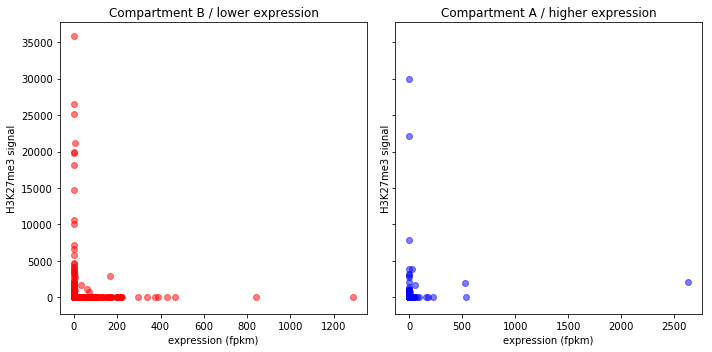

In [24]:
# Plot expression on x axis and H3K27me3 signal on y axis
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10,5))

ax[0].scatter(x=pos_df['fpkm'], y=pos_df['signal'], color='red',
             alpha=0.5)
ax[0].set_title('Compartment B / lower expression')
ax[0].set_xlabel('expression (fpkm)')
ax[0].set_ylabel('H3K27me3 signal')

ax[1].scatter(x=neg_df['fpkm'], y=neg_df['signal'], color='blue',
             alpha=0.5)
ax[1].set_title('Compartment A / higher expression')
ax[1].set_xlabel('expression (fpkm)')
ax[1].set_ylabel('H3K27me3 signal')
    
plt.tight_layout()
plt.show()